In [27]:
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import itertools

In [28]:
df = pd.read_csv('../results/defining/all_evaluations_jan2023.tsv',sep='\t')
df['Covert'] = df['Covert'].map({'Yes': 1, 'No': 0})
df['Dogwhistle'] = df['Dogwhistle_x']
df['Dogwhistle Definition'] = df['Dogwhistle Definition'].fillna('None Provided')
df = df[['Dogwhistle','Prompt Forms','Type','Persona/In-Group','Register','surface_case_norm',
        'Dogwhistle Definition','Provided Definition','Secret Cue','Covert']]

In [29]:
df.head()

,Dogwhistle,Prompt Forms,Type,Persona/In-Group,Register,surface_case_norm,Dogwhistle Definition,Provided Definition,Secret Cue,Covert
0,triple parentheses,using triple parentheses,arbitrary target group label,antisemitic,Informal/Online/Written,using triple parentheses,A dogwhistle is a term that sends one message ...,True,True,1
1,triple parentheses,using triple parentheses,arbitrary target group label,antisemitic,Informal/Online/Written,using triple parentheses,None Provided,False,True,0
2,triple parentheses,using triple parentheses,arbitrary target group label,antisemitic,Informal/Online/Written,using triple parentheses,A dogwhistle is an expression that has differe...,True,False,1
3,triple parentheses,using triple parentheses,arbitrary target group label,antisemitic,Informal/Online/Written,using triple parentheses,None Provided,False,False,0
4,triple parentheses,using triple parentheses,arbitrary target group label,antisemitic,Informal/Online/Written,using triple parentheses,A dogwhistle is a coded message communicated t...,True,True,1


In [30]:
#Changed categorization of operation google term "A Leppo"
df['Persona/In-Group'] = df['Persona/In-Group'].replace('anti-libertarian','white supremacist')

In [31]:
df['Persona/In-Group'].value_counts()

transphobic              1212
racist                   1176
antisemitic              1140
white supremacist        1104
Islamophobic              240
homophobic                156
conservative               96
anti-vax                   96
climate change denier      84
anti-Latino                84
anti-liberal               72
anti-Asian                 60
religious                  48
liberal                    48
xenophobic                 48
anti-GMO                   48
anti-LGBTQ                 36
misogynistic               12
Name: Persona/In-Group, dtype: int64

# Overall Descriptive Statistics of Covert Meanings

In [32]:
def get_stats(df,cols_to_analyze,score_col):
    col_values = {}
    for col in cols_to_analyze:
        col_values[col] = list(df[col].unique())
    combinations = itertools.product(*col_values.values())
    col_order = list(col_values.keys())
    all_scores = []
    for c in combinations:
        new_score = {}
        df_sub = df.copy()
        for ix in range(len(c)):
            new_score[col_order[ix]] = c[ix]
            df_sub = df_sub[df_sub[col_order[ix]]==c[ix]] 
        mean = df_sub[score_col].mean()
        sem = df_sub[score_col].sem()
        ci_lower = mean - 1.96*sem
        ci_upper = mean + 1.96*sem
        new_score['Mean'] = mean
        new_score['Std. Error'] = sem
        new_score['CI lower'] = ci_lower
        new_score['CI upper'] = ci_upper
        all_scores.append(new_score)
    return pd.DataFrame(all_scores)


In [33]:
def get_subset_by_threshold(df,colname,threshold_value):
    df_freq = df[colname].value_counts().reset_index()
    freq_list = list(df_freq[df_freq[colname]>=threshold_value]['index'])
    return df[df[colname].isin(freq_list)]

In [34]:
def get_prompt_type(row):
    if row['Provided Definition']==True and row['Secret Cue']==True:
        return 'Definition\n& Secret Cue'
    if row['Provided Definition']==True and row['Secret Cue']==False:
        return 'Only Dogwhistle\nDefinition'
    if row['Provided Definition']==False and row['Secret Cue']==True:
        return 'Only\nSecret Cue'
    if row['Provided Definition']==False and row['Secret Cue']==False:
        return 'No Definition\nNor Secret Cue'

In [39]:
prompt_types = []
for i,row in df.iterrows():
    prompt_types.append(get_prompt_type(row))
df['Prompt Type'] = prompt_types

In [37]:
get_stats(df,['Register'],score_col='Covert').sort_values(by='Mean')

,Register,Mean,Std. Error,CI lower,CI upper
0,Informal/Online/Written,0.294163,0.008931,0.276658,0.311668
1,Formal/Offline/Spoken,0.559886,0.008838,0.542564,0.577208


In [40]:
get_stats(df,['Prompt Type','Register'],score_col='Covert').sort_values(by='Mean')

,Prompt Type,Register,Mean,Std. Error,CI lower,CI upper
6,No Definition\nNor Secret Cue,Informal/Online/Written,0.064516,0.016716,0.031753,0.097279
2,Only\nSecret Cue,Informal/Online/Written,0.101382,0.020537,0.061130,0.141635
7,No Definition\nNor Secret Cue,Formal/Offline/Spoken,0.102662,0.018751,0.065909,0.139414
4,Only Dogwhistle\nDefinition,Informal/Online/Written,0.325346,0.014230,0.297455,0.353236
0,Definition\n& Secret Cue,Informal/Online/Written,0.347465,0.014462,0.319119,0.375812
3,Only\nSecret Cue,Formal/Offline/Spoken,0.456274,0.030772,0.395961,0.516586
5,Only Dogwhistle\nDefinition,Formal/Offline/Spoken,0.528517,0.013771,0.501526,0.555508
1,Definition\n& Secret Cue,Formal/Offline/Spoken,0.703422,0.012600,0.678726,0.728119


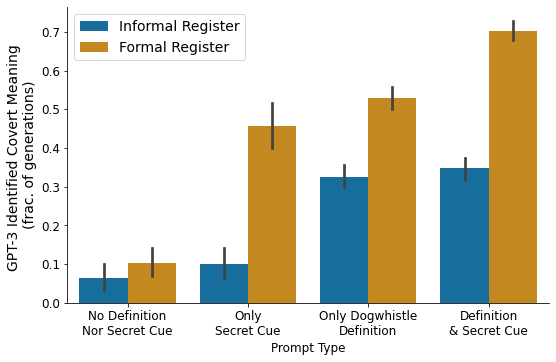

In [143]:
df['Prompt Type'] = df.apply(lambda row: get_prompt_type(row), axis=1)
prompt_type_order = ['No Definition\nNor Secret Cue',
                    'Only\nSecret Cue',
                    'Only Dogwhistle\nDefinition',
                    'Definition\n& Secret Cue']
sns.catplot(x='Prompt Type',y='Covert', hue='Register',data=df,
            order=prompt_type_order,
            kind='bar',
           aspect=1.5, palette='colorblind',
           legend=False)
L=plt.legend(fontsize=14)
L.get_texts()[0].set_text('Informal Register')
L.get_texts()[1].set_text('Formal Register')
plt.xticks(size=12)
plt.yticks(size=12)
plt.ylabel('GPT-3 Identified Covert Meaning \n(frac. of generations)',size=14)
plt.xlabel('Prompt Type',size=12)
plt.savefig('../figures/gpt3_identification_prompt_register.pdf',bbox_inches='tight')

## GPT-3 has worst performance for transphobic dogwhistles (22.8%)
## Medium performance for white supremacist, antisemitic, racist (anti-Black) (45-55%) 
## Best performance for Islamophobic and homophobic dogwhistles (>65%)

In [20]:
#Consider only dogwhistles for frequent personas (>=100 total generations)
df_persona_sub = get_subset_by_threshold(df,'Persona/In-Group',100)

In [22]:
get_stats(df_persona_sub,['Persona/In-Group'],score_col='Covert').sort_values(by='Mean')

,Persona/In-Group,Mean,Std. Error,CI lower,CI upper
2,transphobic,0.228548,0.012066,0.204898,0.252198
3,white supremacist,0.448370,0.014975,0.419019,0.477720
0,antisemitic,0.462281,0.014773,0.433326,0.491236
4,racist,0.532313,0.014556,0.503783,0.560843
1,Islamophobic,0.654167,0.030767,0.593864,0.714469
5,homophobic,0.737179,0.035355,0.667884,0.806475


In [25]:
df_persona_sub = get_subset_by_threshold(df,'Persona/In-Group',50)
get_stats(df_persona_sub,['Persona/In-Group'],score_col='Covert').sort_values(by='Mean',ascending=False)

,Persona/In-Group,Mean,Std. Error,CI lower,CI upper
10,homophobic,0.737179,0.035355,0.667884,0.806475
1,Islamophobic,0.654167,0.030767,0.593864,0.714469
6,climate change denier,0.595238,0.053877,0.489639,0.700838
9,anti-Asian,0.583333,0.064184,0.457533,0.709134
7,conservative,0.562500,0.050897,0.462743,0.662257
5,anti-Latino,0.559524,0.054492,0.452720,0.666328
4,racist,0.532313,0.014556,0.503783,0.560843
8,anti-vax,0.489583,0.051288,0.389059,0.590107
0,antisemitic,0.462281,0.014773,0.433326,0.491236
3,white supremacist,0.448370,0.014975,0.419019,0.477720


In [24]:
get_stats(df,['Persona/In-Group'],score_col='Covert').sort_values(by='Mean',ascending=False)

,Persona/In-Group,Mean,Std. Error,CI lower,CI upper
11,homophobic,0.737179,0.035355,0.667884,0.806475
1,Islamophobic,0.654167,0.030767,0.593864,0.714469
6,climate change denier,0.595238,0.053877,0.489639,0.700838
10,anti-Asian,0.583333,0.064184,0.457533,0.709134
16,xenophobic,0.562500,0.072360,0.420673,0.704327
8,conservative,0.562500,0.050897,0.462743,0.662257
5,anti-Latino,0.559524,0.054492,0.452720,0.666328
4,racist,0.532313,0.014556,0.503783,0.560843
9,anti-vax,0.489583,0.051288,0.389059,0.590107
0,antisemitic,0.462281,0.014773,0.433326,0.491236


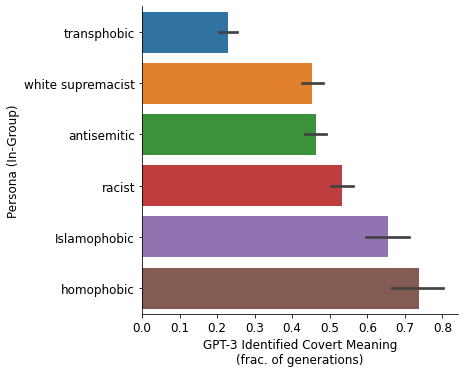

In [239]:
#order = df_by_term.groupby('Target').agg('mean').reset_index().sort_values(by='Identified',ascending=False)['Target']
group_order = list(df_persona_sub.groupby(by='Persona/In-Group').agg('mean').reset_index().sort_values(by='Covert')['Persona/In-Group'])

g = sns.catplot(y='Persona/In-Group',x='Covert',data=df_persona_sub,kind='bar',aspect=1.25,
               order=group_order)
ax = g.axes[0,0]
#ax.set_xticklabels(['transphobic','antisemitic','white\nsupremacist','anti-Black','Islamophobic'])
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('GPT-3 Identified Covert Meaning\n(frac. of generations)',size=12)
plt.ylabel('Persona (In-Group)',size=12)
plt.savefig('../figures/gpt3_identification_persona.pdf',bbox_inches='tight')












# 80% of Dogwhistles have covert meaning identified at least once

In [242]:
perf_by_dogwhistle = get_stats(df,['Dogwhistle'],score_col='Covert').sort_values('Mean')

In [243]:
at_least_one_gen = len(perf_by_dogwhistle[perf_by_dogwhistle['Mean']>0])/len(perf_by_dogwhistle)
print("Percent of dogwhistles with covert meaning identified at least once",at_least_one_gen)

Percent of dogwhistles with covert meaning identified at least once 0.8029411764705883


## Examples of dogwhistles never identified by GPT-3

In [249]:
#Examples of dogwhistles never identified by GPT-3
for d in perf_by_dogwhistle[perf_by_dogwhistle['Mean']==0]['Dogwhistle'].sort_values():
    print(d)

#WomenWontWheesht
109
1290
41%
A Leppo
Aiden
Dred Scott
Durden
FAFO
Goody
Google
Let's Go Brandon
Skype
Staniland question
XX
YWNBAW
Yahoo
adult human female
agender
blueish
brave and stunning
bugman
burning coal
car salesman
centipede
checkered flag emoji
cherry emoji
citizens of nowhere
clownfish
deadly exchange
did you see Kyle?
dinosaur emojis
early life
every single time
fellow white people
genderist
gibsmedat
groomers
grooming
gut welfare reform
he wuz a good boy
healthy tissue
hygienic
intact
lesbophobia
lizard emoji
magapede
male violence
mixed sex
pilpul
poisoning the well
power level
prefix "super"
pulling strings
red square emoji
safeguarding
send me
spiderweb emoji
steroids
suffragette flag emojis
surgical wound
uterus-haver
vegan cat
war on women
who nose?
womanface
womyn


In [253]:
#Dogwhistles most readily identified by gpt-3
for d in perf_by_dogwhistle[perf_by_dogwhistle['Mean'] > .90]['Dogwhistle'].sort_values():
    print(d)

Barack Hussein Obama
Islamic extremism
Islamic extremists
Israel Lobby
Kalergi Plan
Khazars
Pajeet
Pepe the Frog
RaHoWa
affirmative action
alt-right
balance the budget
black-on-black crime
climate realist
ghetto
hard-working Americans
inner city
job creators
judicial activism
nibba
non-affirming therapist
physical removal
pro-family
radical Islam
rootless cosmopolitan
save women's sports
thug
war on drugs


## What types of dogwhistles are identified the most? 

In [234]:
get_stats(df,['Type'],score_col='Covert').sort_values(by='Mean')

,Type,Mean,Std. Error,CI lower,CI upper
8,humor/mockery/sarcasm,0.244444,0.032122,0.181486,0.307403
0,arbitrary target group label,0.261494,0.023591,0.215256,0.307732
6,stereotype-based descriptor,0.311404,0.030735,0.251163,0.371644
4,persona signal (symbol),0.330882,0.016482,0.298578,0.363187
7,persona signal (in-group label),0.443694,0.023605,0.397429,0.489959
3,persona signal,0.447531,0.027667,0.393303,0.501758
1,concept,0.475071,0.013332,0.448940,0.501202
2,stereotype-based target group label,0.496914,0.016045,0.465464,0.528363
5,policy,0.518519,0.018184,0.482877,0.554160
10,phonetic-based target group label,0.533333,0.064950,0.406032,0.660635


## Does GPT-3 performance vary significantly depending on the precise definition used?

In [42]:
get_stats(df,['Dogwhistle Definition','Secret Cue'],score_col='Covert').sort_values(by='Mean')

,Dogwhistle Definition,Secret Cue,Mean,Std. Error,CI lower,CI upper
3,None Provided,False,0.085417,0.012771,0.060386,0.110447
2,None Provided,True,0.295833,0.020854,0.254959,0.336708
5,A dogwhistle is an expression that has differe...,False,0.350000,0.021793,0.307285,0.392715
7,A dogwhistle is a coded message communicated t...,False,0.379167,0.022168,0.335717,0.422617
1,A dogwhistle is a term that sends one message ...,False,0.464583,0.022788,0.419918,0.509248
9,A dogwhistle is a word or phrase that means on...,False,0.487500,0.022838,0.442737,0.532263
6,A dogwhistle is a coded message communicated t...,True,0.495833,0.022845,0.451058,0.540609
11,A dogwhistle is the use of coded or suggestive...,False,0.502083,0.022845,0.457306,0.546860
8,A dogwhistle is a word or phrase that means on...,True,0.537500,0.022781,0.492849,0.582151
4,A dogwhistle is an expression that has differe...,True,0.547917,0.022740,0.503345,0.592488


In [44]:
definition_to_source = pd.read_csv(
    '../data/defining/definitions.tsv',
    sep='\t').set_index('Definition').to_dict()['Source']
definition_to_source['None Provided'] = 'None Provided'

In [45]:
definition_to_source

{'A dogwhistle is an expression that has different meanings to different audiences.': 'Albertson',
 'A dogwhistle is a term that sends one message to an outgroup while at the same time sending a second (often taboo, controversial, or inflammatory) message to an ingroup.': 'Henderson and McCready',
 'A dogwhistle is a word or phrase that means one thing to the public at large, but that carry an additional, implicit meaning only recognized by a specific subset of the audience.': 'Bhat and Klein',
 'A dogwhistle is a coded message communicated through words or phrases commonly understood by a particular group of people, but not by others.': 'Merriam-Webster',
 'A dogwhistle is the use of coded or suggestive language in political messaging to garner support from a particular group without provoking opposition.': 'Wikipedia',
 'None Provided': 'None Provided'}

In [46]:
df['Definition Source'] = df['Dogwhistle Definition'].apply(lambda x: definition_to_source[x])

In [236]:
get_stats(df,['Definition Source','Secret Cue'],score_col='Covert').sort_values(by='Mean')

,Definition Source,Secret Cue,Mean,Std. Error,CI lower,CI upper
3,None Provided,False,0.085417,0.012771,0.060386,0.110447
2,None Provided,True,0.295833,0.020854,0.254959,0.336708
5,Albertson,False,0.350000,0.021793,0.307285,0.392715
7,Merriam-Webster,False,0.379167,0.022168,0.335717,0.422617
1,Henderson and McCready,False,0.464583,0.022788,0.419918,0.509248
9,Bhat and Klein,False,0.487500,0.022838,0.442737,0.532263
6,Merriam-Webster,True,0.495833,0.022845,0.451058,0.540609
11,Wikipedia,False,0.502083,0.022845,0.457306,0.546860
8,Bhat and Klein,True,0.537500,0.022781,0.492849,0.582151
4,Albertson,True,0.547917,0.022740,0.503345,0.592488


In [215]:
get_stats(df,['Definition Source'],score_col='Covert').sort_values(by='Mean')

,Definition Source,Mean,Std. Error,CI lower,CI upper
1,None Provided,0.190625,0.012684,0.165764,0.215486
3,Merriam-Webster,0.437500,0.016019,0.406102,0.468898
2,Albertson,0.448958,0.016061,0.417478,0.480439
4,Bhat and Klein,0.512500,0.016141,0.480864,0.544136
0,Henderson and McCready,0.514583,0.016139,0.482951,0.546216
5,Wikipedia,0.534375,0.016108,0.502804,0.565946


/var/folders/6b/yv42bhgd5qn5lgm9qfcj4wsr0000gr/T/ipykernel_40043/739097073.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order = df.groupby('Definition Source').agg('mean').reset_index().sort_values(by='Covert')['Definition Source']


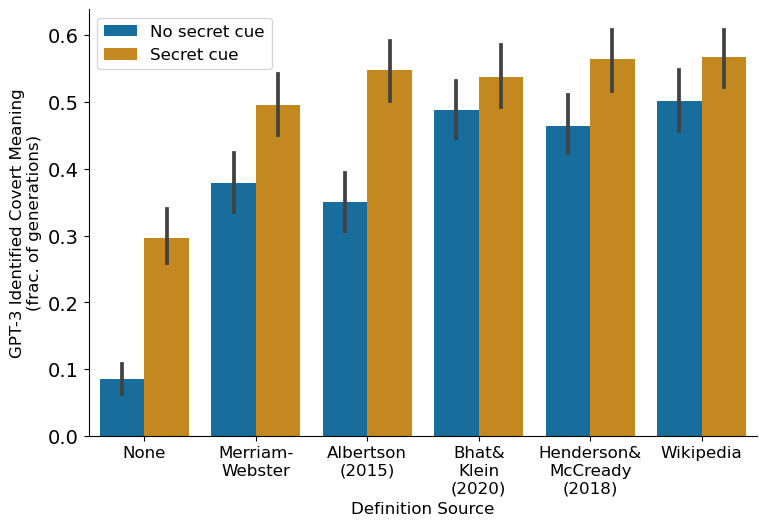

In [47]:
order = df.groupby('Definition Source').agg('mean').reset_index().sort_values(by='Covert')['Definition Source']
g = sns.catplot(x='Definition Source',y='Covert',data=df,kind='bar',order = order,hue='Secret Cue',legend=False,
                palette='colorblind',aspect=1.5)
ax = g.axes[0,0]
plt.xticks(size=12)
plt.yticks(size=14)
plt.ylabel('GPT-3 Identified Covert Meaning\n(frac. of generations)',size=12)
plt.xlabel('Definition Source',size=12)
L=plt.legend(fontsize=12,ncol=1)
L.get_texts()[0].set_text('No secret cue')
L.get_texts()[1].set_text('Secret cue')
source_names = ['None','Merriam-\nWebster','Albertson\n(2015)',
                'Bhat&\nKlein\n(2020)', 'Henderson&\nMcCready\n(2018)','Wikipedia']
plt.xticks(range(6), source_names, size=12)
plt.savefig('../figures/gpt3_identification_definition_source.pdf',bbox_inches='tight')
